<h1>Spam Detection</h1>


<h3>Reading the dataset</h3>

In [17]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import math
from collections import Counter

In [18]:
#reading the csv file using pandas
df = pd.read_csv("spam.csv", encoding= "latin-1")
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


<h3>Cleaning the data</h3>

In [19]:
df =df.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])

#renaming columns and dropping useless columns as well as 
#making all text lowercase and getting rid of punctuation
for i in range(len(df)):
    df.loc[i, "v2"]=df.loc[i, "v2"].lower()
    df.loc[i, "v2"] = df.loc[i, "v2"].strip()

    for k in df.loc[i, "v2"]:
        if k in [",", ".", "!", "?", ";", ":", "'", '"', "(", ")", "[", "]", "{", "}", "<", ">", "/", "\\", "|", "-", "_", "*", "&", "^", "%", "$", "#", "@", "~", "`", "=", "+", "÷"]:
            df.loc[i, "v2"]=df.loc[i, "v2"].replace(k, "")

df= df.rename(columns = {"v1": "Category", "v2": "Message"})

df

,Category,Message
0,ham,go until jurong point crazy available only in ...
1,ham,ok lar joking wif u oni
2,spam,free entry in 2 a wkly comp to win fa cup fina...
3,ham,u dun say so early hor u c already then say
4,ham,nah i dont think he goes to usf he lives aroun...
...,...,...
5567,spam,this is the 2nd time we have tried 2 contact u...
5568,ham,will ì b going to esplanade fr home
5569,ham,pity was in mood for that soany other suggest...
5570,ham,the guy did some bitching but i acted like id ...


<h3>Splitting the Data</h3>

In [20]:

train_data, validation_data, test_data = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
train_data=train_data.reset_index()
test_data = test_data.reset_index()
validation_data = validation_data.reset_index()

/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


<h3>Creating a Word Frequency DataFrame</h3>

In [29]:
messages = ""
messages_ham=""
messages_spam=""

#added all messages together in one string
for i in range(len(train_data)):
    messages+= " "+train_data.loc[i, "Message"]
    
#made the split of the string into a set to get rid of repetitions 
#and then turning it back into a list
unique_words = list(set(messages.split()))

spam_count = []
ham_count = []

#added all ham and spam messages into two different strings
for i in range(len(train_data)):
    if train_data.loc[i, "Category"]=="ham":
        messages_ham+= " "+train_data.loc[i, "Message"]
    else:
         messages_spam+= " "+train_data.loc[i, "Message"]
        
#added the count of each word into a list
for i in unique_words:
    ham_count.append(messages_ham.split().count(i))
    spam_count.append(messages_spam.split().count(i))

#created a dataframe with words and its counts                  
word_freq = pd.DataFrame({
    'Word': unique_words,
    '#Spam': spam_count,
    '#Ham': ham_count
})

word_freq


,Word,#Spam,#Ham
0,agency,0,1
1,mp3,3,1
2,rakhesh,0,1
3,cheery,0,1
4,å£75000,2,0
...,...,...,...
7134,coolmob,1,0
7135,6031,1,0
7136,hogolo,0,1
7137,suffering,0,1


<h3>Visualise the Data</h3>

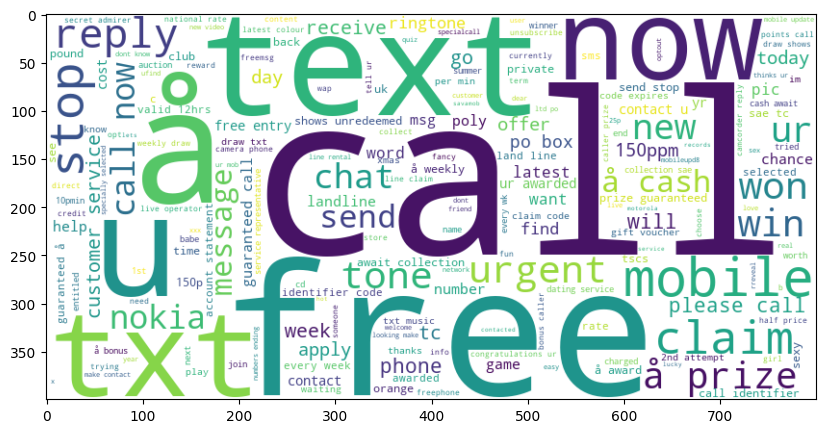

In [22]:
wordcloud = WordCloud(width=800, height=400, background_color= "white").generate(messages_spam)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

<h3>Calculate $P\left(E\middle| S\right)$ and $P\left(E|\lnot S\right)$</h3>

In [23]:
prob_spam= []
prob_ham = []

num_ham = (train_data["Category"]=="ham").sum()
num_spam = (train_data["Category"]=="spam").sum()

prob_dict = {}

#found the count of words over total words and added them into seperate lists
for i in unique_words:
    prob_ham.append((((train_data["Category"]=="ham") & (train_data["Message"].str.contains(i))).sum()+0.5) / (num_ham+1))
    prob_spam.append((((train_data["Category"]=="spam") & (train_data["Message"].str.contains(i))).sum()+0.5) / (num_spam+1))
    prob_dict[i] = [(((train_data["Category"]=="ham") & (train_data["Message"].str.contains(i))).sum()+0.5) / (num_ham+1), (((train_data["Category"]=="spam") & (train_data["Message"].str.contains(i))).sum()+0.5) / (1+num_spam)]

#created a dataframe with words and its probabilities
word_prob = pd.DataFrame({
    'Word': unique_words,
    'P(E|S)': prob_spam,
    'P(E|¬S)': prob_ham
    })

word_prob

,Word,P(E|S),P(E|¬S)
0,agency,0.001157,0.000515
1,mp3,0.008102,0.000515
2,rakhesh,0.001157,0.002231
3,cheery,0.001157,0.000515
4,å£75000,0.005787,0.000172
...,...,...,...
7134,coolmob,0.003472,0.000172
7135,6031,0.003472,0.000172
7136,hogolo,0.001157,0.000515
7137,suffering,0.001157,0.000515


<h3>7. Checking the 'spamliness' of a single word</h3>
<p>Now that we have trained the model, we will test the model.  Before we use the test_data, first let’s check how the model calculates the spamliness of a single word.  This is where we use the Bayes Theorem formula.  We have already calculated $P\left(E\middle| S\right)$ and $P\left(E|\lnot S\right)$, so we can just extract these values from the word_prob DataFrame.</p>
<p>We need to decide on the prior values $P\left(S\right)$ and $P\left(\lnot S\right)$, this is where you can experiment and tweak the model, in this example the prior value for spam was set to $0.4$ and the prior value for not spam or ham was set to $0.6$.</p>
<h3>
$P\left(S\middle|\ E\right)=\frac{P\left(E\middle|\ S\right)P\left(S\right)}{P\left(E\middle|\ S\right)P\left(S\right)+P\left(E|\lnot S\right)P\left(\lnot S\right)}$
</h3>
<pre>
Output
Word = ['free']
P(E|S) = [0.29108392]
P(E|¬S) = [0.01365141]
P(S|E) = [0.93427577]
P(¬S|E) = [0.06572423]
</pre>

<p>[2 Marks]</p>

In [24]:
spanniness = {}

#made a dictionary that maps from words to its spamliness
for index, i in enumerate(word_prob["Word"]):
    prob_spam= word_prob.loc[index,"P(E|S)"]
    prob_ham = word_prob.loc[index,"P(E|¬S)"]
    spanniness[i] = (prob_spam*0.4)/(prob_spam*0.4+prob_ham*0.6)

spanniness

span_words = []
ham_words = []

#added words into spam or ham lists depending on their spamliness
for i in unique_words:
    if spanniness[i] > 0.5:
        span_words.append(i)
    elif spanniness[i] < 0.5:
        ham_words.append(i)
        
print("Word = Free")
print("P(E|S) =", prob_dict["free"][1])
print("P(E|¬S) =", prob_dict["free"][0])
print("P(S|E) =", spanniness["free"])
print("P(¬S|E) =", 1-spanniness["free"])

Word = Free
P(E|S) = 0.26967592592592593
P(E|¬S) = 0.013903192584963954
P(S|E) = 0.9282182990822151
P(¬S|E) = 0.07178170091778491


<h3>8. Checking the 'spamliness' of several words</h3>
<p>To check the spamliness of several words contained in a message we multiply the probabilities.  The model assumes the words appear as independent events hence the naïve Bayes.  In reality of course, words are not independent events, but the model still performs well.  So we use the assumption that the words appear independently, and hence we multiply probabilities, so
$P(S\,|\, x_1,\dots,x_n)\approx \frac{P(S)\underset{i=1}{\overset{n}{\prod}}P(x_i | S)}{P(S)\underset{i=1}{\overset{n}{\prod}}P(x_i | S)+P(\neg S)\underset{i=1}{\overset{n}{\prod}}P(x_i | \neg S)}$

Calculate the probability for each word in a message being spam, you might want to store the calculations in a list named prob_spam.  Likewise create a list for each word not being spam.
Then multiply the probabilities and compare the results.  If the result of multiplying the probabilities for spam is greater than the result of multiplying the probabilities for not spam, then you assume the message as spam.
</p>
<p>If you have a word in your message that is not in the word_prob DataFrame then you can't get the probability.  Skip any words in the message that are not in the word_prob DataFrame.</p>
<p>[2 Marks]</p>

In [25]:
message_spamliness = []

#found probabilities of messages by mutliplying spamliness of all words
for i in train_data["Message"]:
    message_prob_spam = 1
    message_prob_ham = 1
    for k in i.split():
        message_prob_ham*= prob_dict[k][0]
        message_prob_spam*= prob_dict[k][1]

    message_spamliness.append((0.4*message_prob_spam)/(0.4*message_prob_spam+0.6*message_prob_ham))

message_spamliness
    

[1.0,
 0.6555325502872037,
 0.9992132226998784,
 0.8554814115965172,
 0.492409299632372,
 0.1770117247091047,
 1.0,
 0.9817438776121321,
 0.6338355562445572,
 0.14333997449149807,
 0.6544453991786602,
 0.04461156063245576,
 0.02486082996855664,
 0.9479644488544429,
 0.218727659637694,
 0.4349415651428126,
 0.045230759608340776,
 0.01649656090816591,
 0.015692384030288345,
 0.9810512650355305,
 0.9990159136550895,
 1.0,
 1.7484685272799422e-09,
 0.31183307293256074,
 0.5773336864648614,
 0.9865138055044346,
 0.0002693150113238937,
 0.7922889737745188,
 4.143571974975523e-06,
 0.007042392553904002,
 0.0463338614785719,
 0.9999943112698003,
 8.961601488996663e-07,
 0.9862825776425451,
 0.6555825646694148,
 0.999999753910013,
 0.41365467162794106,
 0.27723237817095664,
 0.03354361370545302,
 0.38016517505515823,
 1.910816350013513e-05,
 1.0,
 0.005855402272325255,
 0.006578274492135468,
 0.9485860776159759,
 1.0,
 0.6449603423735064,
 1.0,
 0.051183804508910365,
 0.6918516132703839,
 3.746

<h3>9. Avoiding floating point underflow</h3>
<p>Our aim is to compare two probabilities $P(S|x_1,\dots,x_n)$ with $P(\neg S|x_1,\dots,x_n),$ according to our model introduced in Section 8, both probabilities share a common denominator which does not affect comparison. Hence we will calculate numerators only, which are proportional to $P(S|x_1,\dots,x_n)$ and $P(\neg S|x_1,\dots,x_n).$
</p>

<p>Multiplying a set of small probabilities could result in a floating-point error.  This is where the product becomes too small to be represented correctly.  To avoid this we can take the logarithm of the probabilities and add them.  

To avoid multiplication of small numbers, we use the following property of $\log(x):$</p>
$$
\log(a\cdot b)=\log(a)+\log(b)
$$
<p>i.e. the log of the product is equal to the sum of logs (so instead of multiplying small numbers we will add them):</p>
$$
P(S|x_1,x_2,\dots,x_n)\propto P(S)\cdot P(x_1|S)\cdot \dots \cdot P(x_n|S)$$
<p>becomes</p>
$$\log(P(S|x_1,x_2,\dots,x_n))\propto \log\left(P(S)\cdot P(x_1|S)\cdot \dots  P(x_n|S)\right)=$$ $$
\log(P(S))+\log(P(x_1|S))+\dots+\log(P(x_n|S))
$$
<p>So, to check spam or ham we just compare:</p>
$$
\log(P(S))+\log(P(x_1|S))+\dots+\log(P(x_n|S))
$$
<p>and </p>
$$
\log(P(\neg S))+\log(P(x_1|\neg S))+\dots+\log(P(x_n|\neg S))
$$


Change the equation so that logs are used.
</p>
<p>[2 Mark]</p>

In [26]:
#checks if a message if spam and returns a boolean
def check_spam(message):
    spam = math.log(0.4)
    ham = math.log(0.6)
    
    for i in message.split():

        if i not in prob_dict or prob_dict[i][1]==0 or prob_dict[i][0]==0:
            continue
        spam+= math.log(prob_dict[i][1])
        ham+= math.log(prob_dict[i][0])

    return spam > ham


correct=0
incorrect=0

#calculate accuracy
for index, i in enumerate(test_data["Message"]):

    if check_spam(test_data.loc[index, "Message"]) and test_data.loc[index, "Category"]=="spam":
        correct+=1
    elif not check_spam(test_data.loc[index, "Message"]) and test_data.loc[index, "Category"]=="ham":
        correct+=1
    else:
        incorrect+=1

print(correct/(correct+incorrect))


0.6905829596412556


<h3>11. Improvements</h3>
<p>Utilise the validation set to assess the performance of various word sets in classifying spam and non-spam (ham) emails. Compare the effectiveness of different sets of words to determine their impact on classification accuracy.</p>
<p>[3 Mark]</p>

In [27]:
word_set = []

for index, i in enumerate(unique_words):
    if (spanniness[i]>= 0.99 or spanniness[i]<=0.01) and not i.isdigit():
        word_set.append(i)

#same function but modified where it only uses words that have a certain spamliness
def check_spam2(message):
    spam = math.log(0.4)
    ham = math.log(0.6)
    
    for i in message.split():

        if i not in prob_dict or prob_dict[i][1]==0 or prob_dict[i][0]==0 or not i in word_set:
            continue
        spam+= math.log(prob_dict[i][1])
        ham+= math.log(prob_dict[i][0])

    return spam > ham


correct=0
incorrect=0

#checks accuracy
for index, i in enumerate(validation_data["Message"]):

    if check_spam2(validation_data.loc[index, "Message"]) and validation_data.loc[index, "Category"]=="spam":
        correct+=1
    elif not check_spam2(validation_data.loc[index, "Message"]) and validation_data.loc[index, "Category"]=="ham":
        correct+=1
    else:
        incorrect+=1

print(correct/(correct+incorrect))


0.940754039497307
